In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/infy-nse-share-9623/INFY.NS.csv


In [2]:
#!pip install sktime
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
rcParams['figure.figsize']=10,6

In [4]:
dataset=pd.read_csv("/kaggle/input/infy-nse-share-9623/INFY.NS.csv")
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,0.794921,0.796679,0.791015,0.796679,0.533122,204800.0
1,1996-01-02,0.794921,0.798828,0.793457,0.793457,0.530966,204800.0
2,1996-01-03,0.798828,0.798828,0.798828,0.798828,0.534560,102400.0
3,1996-01-04,0.791015,0.794921,0.791015,0.793554,0.531030,307200.0
4,1996-01-05,0.784179,0.784179,0.784179,0.784179,0.524757,51200.0


In [5]:
dataset['Date']=pd.to_datetime(dataset['Date'],infer_datetime_format=True)
indexedDataset=dataset.set_index(['Date'])

In [6]:
from datetime import datetime
import dateutil.parser
indexedDataset = indexedDataset[indexedDataset.index>dateutil.parser.parse("2000-01-01")]
indexedDataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,122.070313,122.071877,122.070313,122.071877,83.094604,657536.0
2000-01-04,131.250000,131.837891,126.976563,131.686722,89.639496,7191808.0
2000-01-05,122.664063,126.953125,121.151955,121.151955,82.468430,21069440.0
2000-01-06,119.192581,119.531250,111.459763,111.459763,75.870964,10495616.0
2000-01-07,102.542969,102.542969,102.542969,102.542969,69.801239,971392.0


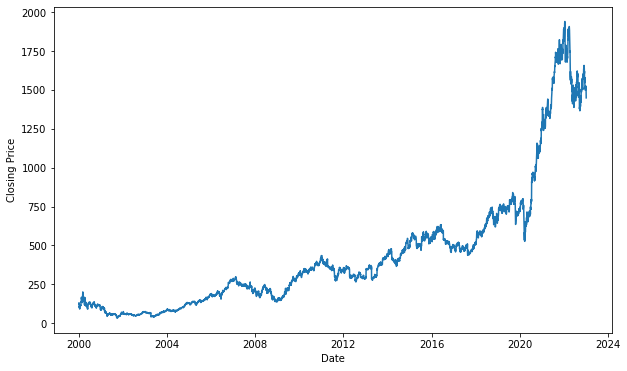

In [7]:
infy = indexedDataset['Close']
infy=pd.DataFrame({'Close':infy})
infy['Close']=infy['Close'].ffill()
#Plot the graph
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.plot(infy)

In [8]:
rollmean = infy.rolling(window=365).mean()
rollstd = infy.rolling(window=365).std()
print(rollmean,rollstd)

                  Close
Date                   
2000-01-03          NaN
2000-01-04          NaN
2000-01-05          NaN
2000-01-06          NaN
2000-01-07          NaN
...                 ...
2023-01-02  1631.907672
2023-01-03  1631.748083
2023-01-04  1631.581919
2023-01-05  1631.399727
2023-01-06  1631.121508

[5760 rows x 1 columns]                  Close
Date                  
2000-01-03         NaN
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
...                ...
2023-01-02  140.783318
2023-01-03  140.874398
2023-01-04  141.000353
2023-01-05  141.159686
2023-01-06  141.420297

[5760 rows x 1 columns]


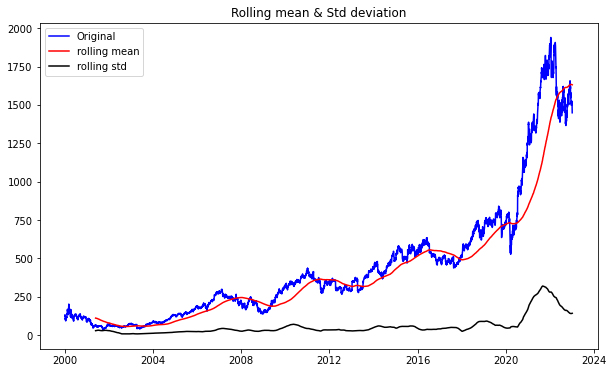

In [9]:
#Plotting rolling statistics
orig=plt.plot(infy,color='blue',label='Original')
mean=plt.plot(rollmean,color='red',label='rolling mean')
std=plt.plot(rollstd,color='black',label='rolling std')
plt.legend(loc='best')
plt.title('Rolling mean & Std deviation')
plt.show(block=False)

In [10]:
#Perform Dickey-Fuller test for testing stationarity
from statsmodels.tsa.stattools import adfuller

print('Result of Dickey Fuller Test:')
dftest = adfuller(infy['Close'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#LagsUsed','Number of observation used'])
for key,value in dftest[4].items():
    dfoutput['Critical Vlue (%s)'%key] = value
    
print(dfoutput)

Result of Dickey Fuller Test:
Test Statistic                   1.139482
p-value                          0.995540
#LagsUsed                       34.000000
Number of observation used    5725.000000
Critical Vlue (1%)              -3.431493
Critical Vlue (5%)              -2.862045
Critical Vlue (10%)             -2.567039
dtype: float64


In [11]:
diffinfy = infy - infy.shift(1)
diffinfy.bfill(inplace=True)
diffinfy.head(10)

,Close
Date,
2000-01-03,9.614845
2000-01-04,9.614845
2000-01-05,-10.534767
2000-01-06,-9.692192
2000-01-07,-8.916794
2000-01-10,4.935936
2000-01-11,-8.598046
2000-01-12,3.287499
2000-01-13,-7.710549


In [12]:
from statsmodels.tsa.stattools import adfuller
def teststationarity(timeseries):
    
    #Rolling Statistics
    movingaverage = timeseries.rolling(window=365).mean()
    movingstd = timeseries.rolling(window=365).std()
    
    #Plot Rolling statistics
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(movingaverage,color='red',label='rolling mean')
    std=plt.plot(movingstd,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Std deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller TEst
    print("Results of the Dickey Fuller Test")
    dftest = adfuller(timeseries['Close'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#LagsUsed','Number of observation used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Vlue (%s)'%key] = value
    
    print(dfoutput)

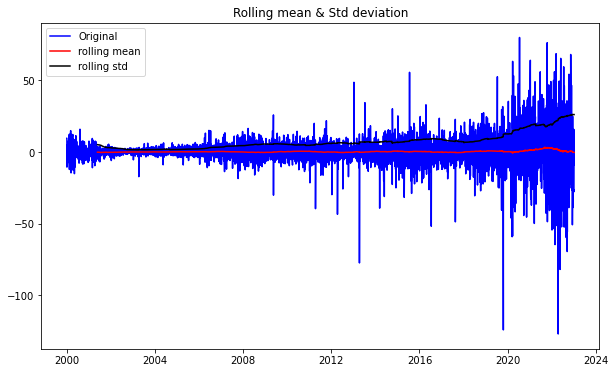

Results of the Dickey Fuller Test
Test Statistic               -1.438856e+01
p-value                       8.904041e-27
#LagsUsed                     3.400000e+01
Number of observation used    5.725000e+03
Critical Vlue (1%)           -3.431493e+00
Critical Vlue (5%)           -2.862045e+00
Critical Vlue (10%)          -2.567039e+00
dtype: float64


In [13]:
teststationarity(diffinfy)

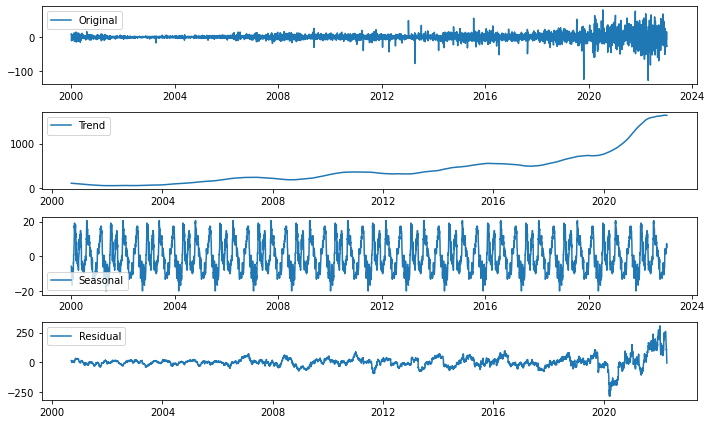

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(infy,period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(diffinfy,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()
#print(decomposition.collect())

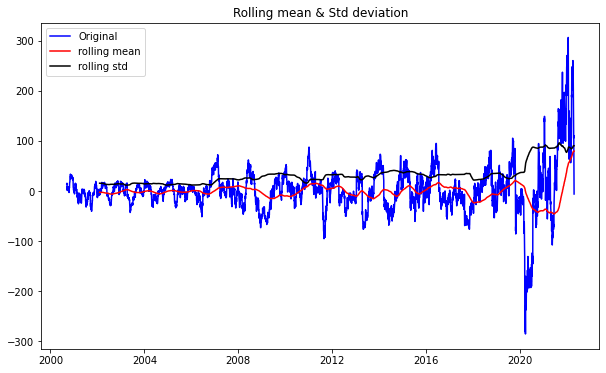

Results of the Dickey Fuller Test
Test Statistic                  -4.759768
p-value                          0.000065
#LagsUsed                       33.000000
Number of observation used    5362.000000
Critical Vlue (1%)              -3.431570
Critical Vlue (5%)              -2.862079
Critical Vlue (10%)             -2.567057
dtype: float64


In [15]:
residualdecompose = residual
residualdecompose.dropna(inplace=True)
teststationarity(residualdecompose.to_frame().rename(columns={"resid": "Close"}))

Text(0.5, 1.0, 'Partial Autocorrelation Function')

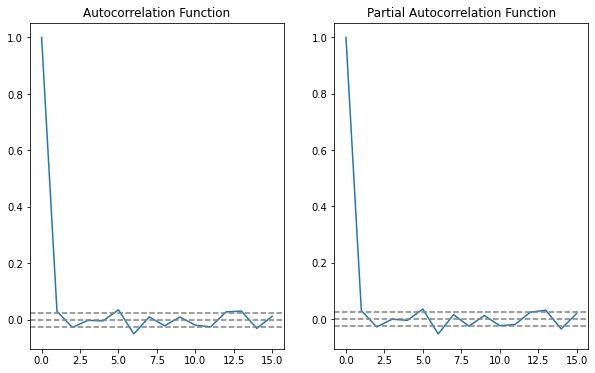

In [16]:
#ACF and PACF graphs
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(diffinfy,nlags=15)
lag_pacf = pacf(diffinfy,nlags=15,method = 'ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle="--",color='grey')
plt.axhline(y=-1.96/np.sqrt(len(diffinfy)),linestyle="--",color='grey')
plt.axhline(y=1.96/np.sqrt(len(diffinfy)),linestyle="--",color='grey')
plt.title("Autocorrelation Function")

#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle="--",color='grey')
plt.axhline(y=-1.96/np.sqrt(len(diffinfy)),linestyle="--",color='grey')
plt.axhline(y=1.96/np.sqrt(len(diffinfy)),linestyle="--",color='grey')
plt.title("Partial Autocorrelation Function")


#The p value is 2 from the PACF graph and the q value is 2 from the ACF graph

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


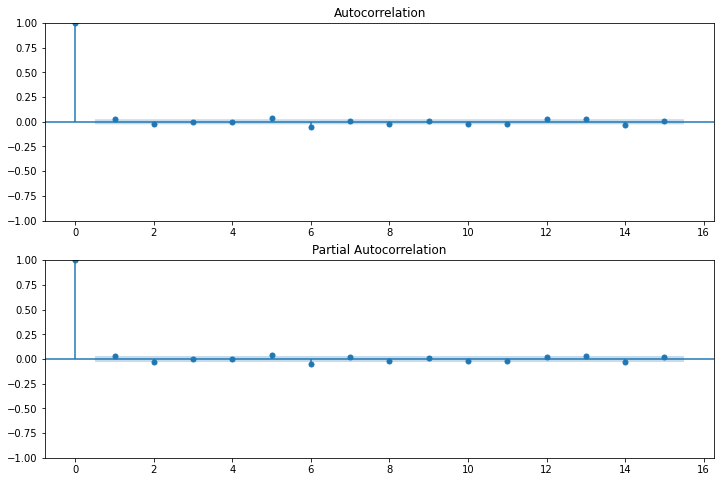

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig1 = plot_acf(diffinfy['Close'],lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig2 =plot_pacf(diffinfy['Close'],lags=15,ax=ax2)

In [18]:
#Fitting an AUTOARIMA for calculating p and q
model_autoARIMA = auto_arima(diffinfy, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=2, # maximum p and q           
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                            Trend=True,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
#model_autoARIMA.plot_diagnostics(figsize=(15,8))
#plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46818.286, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45377.572, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46816.287, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44676.558, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=44674.562, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=45375.575, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=1.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=1.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 13.528 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5760
Model:        

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


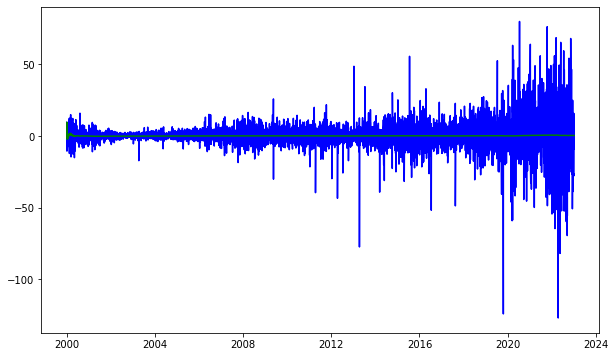

In [19]:
#Fitting an ARIMA model in the timeseries
from statsmodels.tsa.arima.model import ARIMA

#MA Model
model = ARIMA(diffinfy,order=(0,1,1))
results_AR = model.fit()
plt.plot(diffinfy,color="blue")
plt.plot(results_AR.fittedvalues,color='green')
#plt.title('RSS: %.4f' % sum((results_AR.fittedvalues - datasetlogdiffshifting['Close'])**2))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


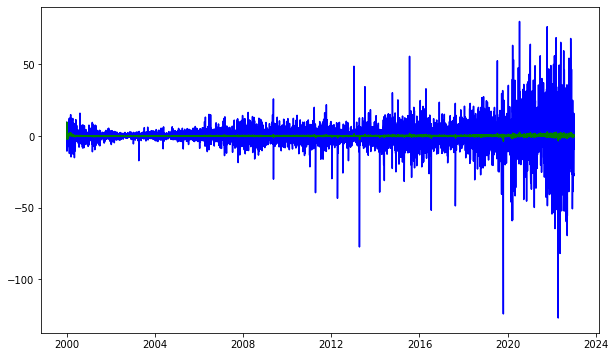

In [20]:
#Fitting an ARIMA model in the timeseries
from statsmodels.tsa.arima.model import ARIMA

#AR Model
model = ARIMA(diffinfy,order=(1,1,1))
results_AR = model.fit()
plt.plot(diffinfy,color="blue")
plt.plot(results_AR.fittedvalues,color='green')
#plt.title('RSS: %.4f' % sum((results_AR.fittedvalues - datasetlogdiffshifting['Close'])**2))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


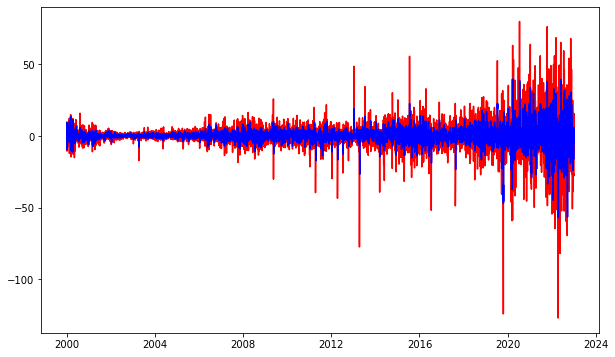

In [21]:
#Fitting an ARIMA model in the timeseries - THE BEST MODEL

#ARIMA Model
model = ARIMA(diffinfy,order=(2,1,0))
results_AR = model.fit()
plt.plot(diffinfy,color="red")
plt.plot(results_AR.fittedvalues,color='blue')

In [22]:
predictionsARIMAdiff = pd.Series(results_AR.fittedvalues,copy=True)

pred_ARIMA_diff_cumsum = predictionsARIMAdiff.cumsum()
print(pred_ARIMA_diff_cumsum.head())

Date
2000-01-03     0.000000
2000-01-04     9.613947
2000-01-05    19.228288
2000-01-06    21.394605
2000-01-07    18.001852
dtype: float64


In [23]:
predictions_ARIMA = pd.Series(diffinfy['Close'].iloc[0],index=diffinfy.index)
predictions_ARIMA = predictions_ARIMA.add(pred_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA.head()

Date
2000-01-03     9.614845
2000-01-04    19.228792
2000-01-05    28.843133
2000-01-06    31.009450
2000-01-07    27.616697
dtype: float64

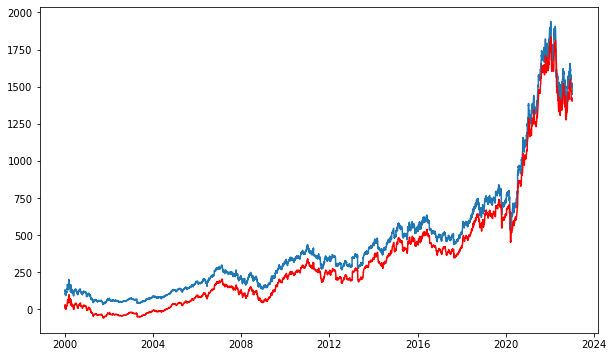

In [24]:
#predictionsARIMA = np.exp(predictions_ARIMA_log)
plt.plot(infy)
plt.plot(predictions_ARIMA,color="red")

In [25]:
finaldf = pd.DataFrame({"Actual": infy['Close'], "Predicted": predictions_ARIMA, "Residual": infy['Close']-predictions_ARIMA})
finaldf

,Actual,Predicted,Residual
Date,,,
2000-01-03,122.071877,9.614845,112.457032
2000-01-04,131.686722,19.228792,112.457930
2000-01-05,121.151955,28.843133,92.308822
2000-01-06,111.459763,31.009450,80.450313
2000-01-07,102.542969,27.616697,74.926272
...,...,...,...
2023-01-02,1524.000000,1418.061508,105.938492
2023-01-03,1522.550049,1423.686591,98.863458
2023-01-04,1494.800049,1424.584299,70.215750


                 0
count  5760.000000
mean     -0.010031
std      11.696142
min    -124.189739
25%      -3.697987
50%      -0.087194
75%       3.513283
max      82.634773


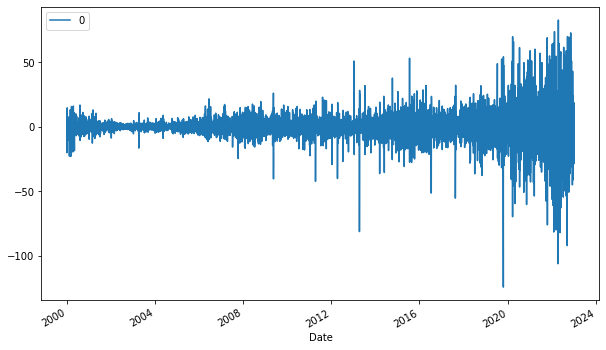

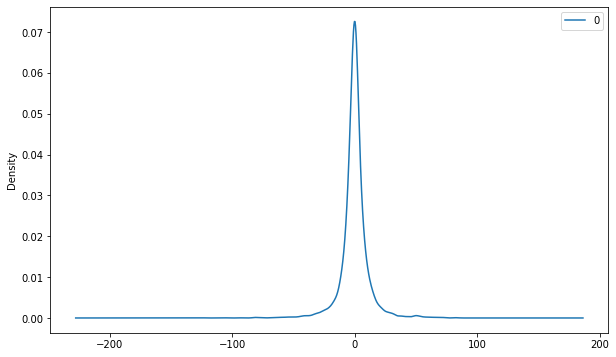

In [26]:
residuals = pd.DataFrame(results_AR.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [27]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5760
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -22334.281
Date:                Thu, 12 Jan 2023   AIC                          44674.562
Time:                        21:48:21   BIC                          44694.538
Sample:                             0   HQIC                         44681.513
                               - 5760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6303      0.005   -123.318      0.000      -0.640      -0.620
ar.L2         -0.3390      0.005    -65.411      0.000      -0.349      -0.329
sigma2       136.7609      0.909    150.472      0.000     134.980     138.542
===================================================================================
Ljung-Box (L1) (Q):                  41.33   Jarque-Bera (JB):             45471.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.21   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

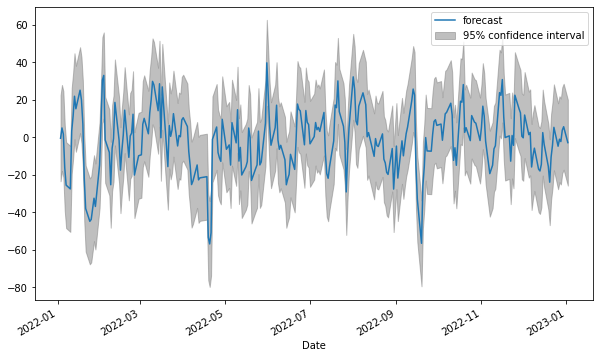

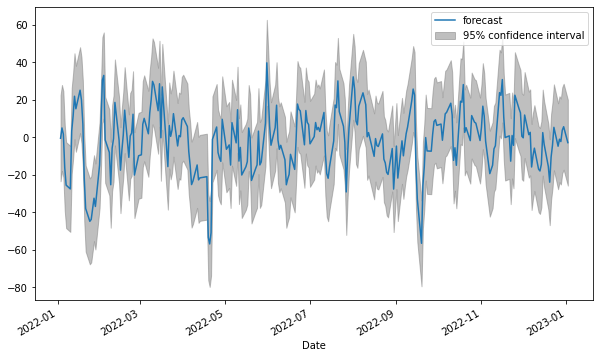

In [28]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(results_AR,start='2022', end='2023')

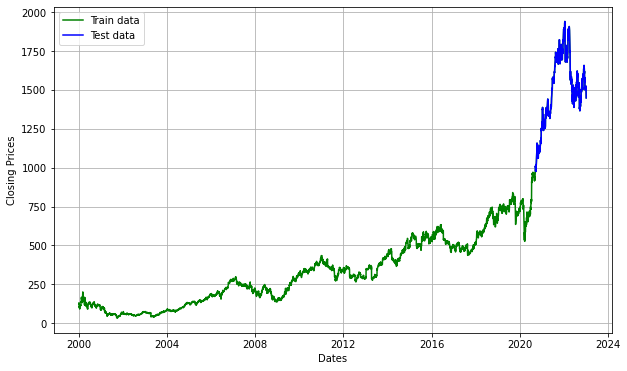

In [29]:
#split data into train and training set
train_data, test_data = infy[3:int(len(infy)*0.9)], infy[int(len(infy)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(infy, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [30]:
#prediction
predstart = test_data.index[0]
predend = test_data.index[-1]
print(predstart)
predend

2020-09-15 00:00:00


Timestamp('2023-01-06 00:00:00')

<AxesSubplot:xlabel='Date'>

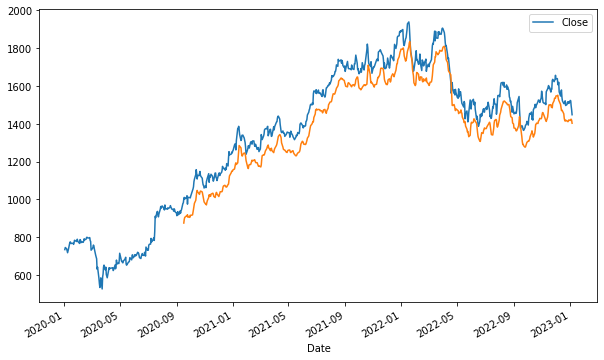

In [31]:
infy[infy.index>'2020-01-01'].plot()
predictions_ARIMA[predictions_ARIMA.index>predstart].plot()